<a href="https://colab.research.google.com/github/Ajitnag/ACMIITGN/blob/main/GenerativeNetwork_ACMIKDD_Summer_FMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Networks

## Importing all the libraries

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, layers, losses
import matplotlib.pyplot as plt
from matplotlib import style
from tqdm import tqdm
style.use('seaborn')

np.random.seed(3407)
tf.random.set_seed(3407)

## Parameters

In [ ]:
batch_size    = 128
latent_dim    = 128

In [ ]:
# !rm -rf 'experiments'

## Data Processing

In [ ]:
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.fashion_mnist.load_data()

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

4431872/4422102 [==============================] - 0s 0us/step
(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


In [ ]:
X_train = np.expand_dims(X_train, axis=-1)
X_train = np.concatenate([X_train, X_train, X_train], axis=-1)
print(X_train.shape)

(60000, 28, 28, 3)


In [ ]:
X_train = (np.float32(X_train) - 127.5) / 127.5

In [ ]:
def custom_resize(X, Y):
    return (tf.image.resize(X, (32, 32)), Y)

def get_batch(X, Y, batch_size):
    return tf.data.Dataset.from_tensor_slices((X, Y)).map(custom_resize).shuffle(buffer_size=2*batch_size).batch(batch_size)

train_batch = get_batch(X_train, Y_train, batch_size)

In [ ]:
X, Y = next(iter(train_batch))
print(X.shape, Y.shape)

(128, 32, 32, 3) (128,)


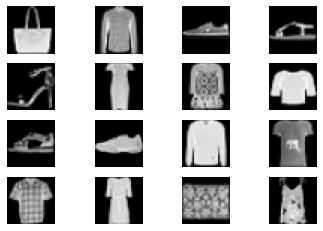

In [ ]:

def show_batch_images(X):
    X = np.clip( np.uint8( ((X.numpy() * 0.5) + 0.5) * 255 ), 0, 255)
    X = X[:16]
    col = 4
    row = X.shape[0] // col
    for r in range(row):
        for c in range(col):
            plt.subplot2grid((row, col), (r, c), rowspan=1, colspan=1)
            plt.grid('off')
            plt.axis('off')
            plt.imshow(X[r*col+c])
    plt.show()

show_batch_images(X)

## GAN Network

### Generator

In [ ]:
class Generator(Model):
    def __init__(self):
        super(Generator, self).__init__()
        filters     = [1024, 512, 256, 128]
        kernels     = [   3,   3,   3,   3]
        strides     = [   4,   2,   2,   2]
        self.depth  = len(filters)
        kernel_init = tf.keras.initializers.TruncatedNormal(stddev=0.02)
        self.conv   = [layers.Conv2DTranspose(filters=filters[i], kernel_size=kernels[i], strides=strides[i], padding='same', kernel_initializer=kernel_init, use_bias=False) for i in range(self.depth)]
        self.norm   = [layers.BatchNormalization() for _ in range(self.depth)]
        self.act    = [layers.LeakyReLU() for _ in range(self.depth)]
        self.final  = layers.Conv2D(filters=3, kernel_size=3, strides=1, padding='same', kernel_initializer=kernel_init, activation='tanh', use_bias=False)
    
    @tf.function
    def call(self, x):
        for i in range(self.depth):
            x = self.act[i]( self.norm[i]( self.conv[i]( x ) ) )
            # print(x.shape)
        x = self.final(x)
        # print(x.shape)
        return x

### Discriminator

In [ ]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        filters     = [ 128, 256, 512, 1024]
        kernels     = [   3,   3,   3,    3]
        strides     = [   1,   2,   2,    2]
        self.depth  = len(filters)
        kernel_init = tf.keras.initializers.TruncatedNormal(stddev=0.02)
        self.conv   = [layers.Conv2D(filters=filters[i], kernel_size=kernels[i], strides=strides[i], padding='same', kernel_initializer=kernel_init, use_bias=False) for i in range(self.depth)]
        self.norm   = [layers.BatchNormalization() for _ in range(self.depth)]
        self.act    = [layers.LeakyReLU() for _ in range(self.depth)]
        self.final  = layers.Conv2D(filters=1, kernel_size=3, strides=1, padding='same', activation='sigmoid')
    
    @tf.function
    def call(self, x):
        for i in range(self.depth):
            x = self.act[i]( self.norm[i]( self.conv[i]( x ) ) )
            # print(x.shape)
        x = self.final( x )
        x = tf.squeeze(x, axis=-1)
        # print(x.shape)
        return x

### GAN

In [ ]:
class GAN(Model):
    def __init__(self):
        super(GAN, self).__init__()
        self.gen = Generator()
        self.dis = Discriminator()

test_GAN = GAN()
print('Generator')
test_GAN.gen(tf.random.uniform(shape=(1, 1, 1, latent_dim), minval=-1.0, maxval=1.0))
print('Discriminator')
test_GAN.dis(tf.random.normal(shape=(1, 32, 32, 3)))

Generator
Discriminator


<tf.Tensor: shape=(1, 4, 4), dtype=float32, numpy=
array([[[0.5085861 , 0.5072432 , 0.5012803 , 0.49908003],
        [0.502585  , 0.49520737, 0.49992707, 0.50004405],
        [0.48971635, 0.499797  , 0.4990546 , 0.49947578],
        [0.4933697 , 0.49753478, 0.49935746, 0.5012277 ]]], dtype=float32)>

## Train Method

In [ ]:
@tf.function
def train_step(gan_model, gen_opt, dis_opt, real_image, batch_size, latent_dim):
    
    latent_vector = tf.random.uniform(shape=(batch_size, 1, 1, latent_dim), minval=-1.0, maxval=1.0)
    
    def train_dis(gan_model, dis_opt, real_image):
        with tf.GradientTape() as tape:
            fake_image = gan_model.gen(latent_vector, training=False)
            real_out   = gan_model.dis(real_image, training=True)
            fake_out   = gan_model.dis(fake_image, training=True)
            loss       = dis_loss(real_out, fake_out)
        variables = gan_model.dis.trainable_variables
        gradients = tape.gradient(loss, variables)
        dis_opt.apply_gradients(zip(gradients, variables))
        return loss
    
    def train_gen(gan_model, gen_opt):
        with tf.GradientTape() as tape:
            fake_image = gan_model.gen(latent_vector, training=True)
            fake_out   = gan_model.dis(fake_image, training=False)
            loss       = gen_loss(fake_out)
        variables = gan_model.gen.trainable_variables
        gradients = tape.gradient(loss, variables)
        gen_opt.apply_gradients(zip(gradients, variables))
        return loss
    
    d_loss = train_dis(gan_model, dis_opt, real_image)
    g_loss = train_gen(gan_model, gen_opt)
    return d_loss, g_loss

In [ ]:
def dis_loss(real_out, fake_out):
	real = tf.convert_to_tensor(np.random.randint(low=7, high=12, size=real_out.shape)/10.0)
	fake = tf.convert_to_tensor(np.random.randint(low=0, high=3, size=fake_out.shape)/10.0)
	real_loss  = losses.BinaryCrossentropy()(real, real_out)
	fake_loss  = losses.BinaryCrossentropy()(fake, fake_out)
	total_loss = (real_loss + fake_loss)/2.0
	return total_loss

def gen_loss(dis_fake):
	real = tf.ones_like(dis_fake)
	fake_loss = losses.BinaryCrossentropy()(real, dis_fake)
	return fake_loss

## Main Method

In [ ]:
gan_model = GAN()
gen_opt   = tf.keras.optimizers.Adam(learning_rate=3e-4, beta_1=0.2, beta_2=0.5)
dis_opt   = tf.keras.optimizers.Adam(learning_rate=3e-4, beta_1=0.2, beta_2=0.5)
ckpt      = tf.train.Checkpoint(step=tf.Variable(1), model=gan_model, gen_opt=gen_opt, dis_opt=dis_opt)
ckpt_man  = tf.train.CheckpointManager(ckpt, directory='experiments/gan_ckpt', max_to_keep=10)
ckpt.restore(ckpt_man.latest_checkpoint)
START     = int(ckpt.step) // len(train_batch)
EPOCHS    = 80
save_freq = 200
sample_latent = tf.random.uniform(shape=(8, 1, 1, latent_dim), minval=-1.0, maxval=1.0)
if ckpt_man.latest_checkpoint:
    print('Restored from the latest epoch: {}'.format(START))

In [ ]:
for epoch in range(START, EPOCHS):
    mean_g_loss = tf.keras.metrics.Mean()
    mean_d_loss = tf.keras.metrics.Mean()

    tq = tqdm(train_batch)

    for idx, (X, Y) in enumerate(tq, start=1):
        d_loss, g_loss = train_step(gan_model, gen_opt, dis_opt, X, batch_size, latent_dim)
        mean_g_loss.update_state(g_loss)
        mean_d_loss.update_state(d_loss)

        ckpt.step.assign_add(1)
        
        if (idx%save_freq) == 0:
            ckpt_man.save()

        tq.set_description('Epoch: {} GLoss: {} DLoss: {}'.format(epoch, mean_g_loss.result(), mean_d_loss.result()))
        # break
    
    fake_images = gan_model.gen(sample_latent, training=False)
    show_batch_images(fake_images)
    # break

## MNIST Result (80 epochs)

<img src="https://s8.gifyu.com/images/GAN_MNIST.gif" width="18%"></img>

## FMNIST Result (20 epochs)

<img src="https://s8.gifyu.com/images/GAN_FMNIST.gif" width="18%"></img>